In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
plt.close('all')
import random
import os
import math

In [35]:
def prob(x0,y0,x,y,a,A):
    r=np.sqrt((x-x0)**2+(y-y0)**2)
    if r==0:
        return 1
    else:
        p=A*np.exp(-(r**a))#A/(r**(a))
        #print(p)
        return p
   
    
def makec(p):
    p=int(p*100)
    t=np.random.random_integers(100)
    #print(t,p)
    if p>t:
        return True
    else:
        return False
    
    
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = (r * a + (1.0 - a) * R) /255
    rgb[:,:,1] = (g * a + (1.0 - a) * G) /255
    rgb[:,:,2] = (b * a + (1.0 - a) * B) /255

    return np.asarray( rgb, dtype='uint8' )


def circle(x0,y0,r):
    
    x1=np.linspace(x0-r,x0+r,3000,endpoint=True)
    x2=np.linspace(x0-r,x0+r,3000,endpoint=True)
    y1=np.sqrt(r**2-(x1-x0)**2)+y0
    y2=-1*np.sqrt(r**2-(x1-x0)**2)+y0
    x=np.append(x1,x2)
    y=np.append(y1,y2)
        
    return x,y 

def circletest(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    #print('d',d,r1,r0)
    
    # non intersecting
    if d > r0 + r1 and r0 != r1:
        #print('1')
        return 0
    # One circle within other
    if d < abs(r0-r1):
        #print('2')
        return 1
    # coincident circles
    if d == 0 and r0 == r1:
        #print('3')
        return 0
    else:
        #print('4')
        return 1

    
def splitprob(r,low,high):
    if r <= low:
        diff = 0
    else:
        diff = ((1/(high-low))**3 * (r-low)**3)*100
    return 100-diff

def distance(circle_a, circle_b):
    return ((circle_a.x - circle_b.x) ** 2 + (circle_a.y - circle_b.y) ** 2) ** 0.5
    
def circletest_array(x0, y0, r0):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1
    c_m=np.zeros((len(x0),len(x0)))
    
    
    for i in range(len(x0)):
         for j in range(len(x0)):
                c_m[i,j]=circletest(x0[i], y0[i], r0[i], x0[j], y0[j], r0[j])
    
    #print('sum',np.sum(c_m))
    return np.sum(c_m)
    
def ini_pic(b, r_mu, r_sig, pix, t, run, bg=False):
    my_dpi = 96
    
    if not os.path.isdir('./' + str(run)):
        os.mkdir('./' + str(run))
        os.mkdir('./' + str(run) + '_GT')
    
    fig = plt.figure(figsize=(pix / my_dpi, pix / my_dpi), dpi=my_dpi)
    ax = fig.gca()
    
    circles = []
    
    x=np.array([])
    y=np.array([])
    x0c=np.array([2])
    y0c=np.array([0.5])
    rc=np.array([0])
    split_prob=np.array([0])
    
    x_pos = np.linspace(0.01 * r_mu, 1 - 0.01 * r_mu, 500)
    y_pos = np.linspace(0.01 * r_mu, 1 - 0.01 * r_mu, 500)
    
    for _ in range(b):
        x0 = np.random.choice(x_pos)
        y0 = np.random.choice(y_pos)
        r_com = np.random.normal(r_mu, r_sig, 1)
        
        circle = Circle(x0, y0, r_com)
        circles.append(circle)
    
    resolve_all_overlaps(circles)
    
    # Extract updated x, y, r values for plotting
    xu, yu, ru = zip(*[(circle.x, circle.y, circle.radius) for circle in circles])
    
    x0c = np.append(x0c,xu)
    y0c = np.append(y0c,yu)
    rc = np.append(rc,ru)
    
    split_prob = [100 - splitprob(radius, 0.035, 0.06) for radius in rc]
    
    for circle in circles:
        circ = plt.Circle((circle.x, circle.y), circle.radius, color='red', fill=False)
        ax.add_patch(circ)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig('./' + str(run) + '/' + str(t) + '.png', dpi=my_dpi, transparent=False)
    plt.close()
    
    r_count = np.unique(rc)
    ide = np.append(-1, np.arange(1, b + 1))
    '''
    if len(r_count) < b:
        print('!!!!!!!!!!!!!!!!!', len(r_count))
        x0c, y0c, rc, ide, split_prob = ini_pic(b, r_i, pix, t, run, bg=False)
    '''
    return x0c, y0c, rc, ide, split_prob

def gt(x,y,r,t,run,ide,split_prob,split_id=0,savefile=True,shuffle=False):
    
    
    #plt.rcParams['axes.facecolor'] = 'black'
    my_dpi=96
    
    #print('r',r,np.mean(r))


    t_v=np.ones(len(x))*t
    
    if t==0:
        split_id=np.zeros(len(x))
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    c = ['#e43b1a','#4a7d5c', '#e5cb14', "#281a32",'#f5b8bc','#d2d7da','#346fb6','#c76b69','#2e2f44','#ca7413']

    
    for i in range(len(x)):
        u=np.random.random_integers(9)
        circ=plt.Circle((x[i], y[i]), r[i], color=c[1],fill=True)
        #circ=plt.Circle((x[i], y[i]), r[i], color='black',fill=True)
        ax.add_patch(circ)
    
    plt.axis('off')
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False)
    
    if shuffle:
        ind = np.argsort(x) 
        #print('ind',ind)
        random.shuffle(ind)
        #print('ind',ind)
        x=np.array(x)
        y=np.array(y)
        r=np.array(r)
        #print('x',x)
        #print('y',y)
        x= np.take_along_axis(x, ind, axis=-1)  
        #print('x2',x)
        
        y=np.take_along_axis(y, ind, axis=-1) 
        
        #print('y2',y)
        #print('ind2',ind)
        r=np.take_along_axis(r, ind, axis=-1)
        ide=np.take_along_axis(ide, ind, axis=-1)
        split_id=np.take_along_axis(split_id, ind, axis=-1)
        split_prob=np.take_along_axis(split_prob, ind, axis=-1)
    
    
    
    if savefile:
        if t==0:
            np.savetxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt', np.c_[x,y,r,ide,split_id,split_prob,t_v],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
        else:    
            xl,yl,rl,idel,split_l,s_pr_l,t_vl= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
            
            xl=np.append(xl,x)
            yl=np.append(yl,y)
            rl=np.append(rl,r)
            t_vl=np.append(t_vl,t_v)
            idel=np.append(idel,ide)
            split_l=np.append(split_l,split_id)
            s_pr_l=np.append(s_pr_l,split_prob)
            np.savetxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt', np.c_[xl,yl,rl,idel,split_l,s_pr_l,t_vl],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
    plt.close()

def move(x,y,r,mv,t,pix,run,ide,reco=True,forget=True,directed=0):
    
    
    vec=np.linspace(0,2*np.pi,500)
    
    my_dpi=96
    n=pix
    my_dpi=96
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    
    plt.axis('off')
    
    plt.gca().set_aspect('equal', adjustable='box')
    ax = fig.gca()
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    

    
    #xp=np.array([0,1])
    #yp=np.array([0,1])
    
    pl=True
    
    

        

    re = np.array([])
    x0c=np.array([])
    y0c=np.array([])
    r0c=np.array([])
    idec=np.array([])
    split_id=np.array([])
    split_prob=np.array([])
    flag=0

       
    for i in range(len(x)):
        x_ra=np.random.random_integers(10)
        y_ra=np.random.random_integers(10)
        phi=np.random.choice(vec)
        x_n=x[i]+(x_ra/10)*mv*np.sin(phi)
        y_n=y[i]+(y_ra/10)*mv*np.cos(phi)
        
        
        r_e0=np.random.randint(0, 2)
        if r[i] < 0.028:
            r_e0 = np.random.random_integers(45,55)
            
        re=np.append(re,r_e0)
        #print('ri0',r[i])
        r[i] = r[i]*(1+(r_e0/100))
        #print('ri1',r[i])

        if x_n < 0 or x_n > 1:
            x_n=x[i]-mv*np.sin(phi)

        if y_n < 0 or y_n > 1:
            y_n=y[i]-mv*np.cos(phi)


        sp=np.random.random_integers(99)
        print('ri',r[i])
        if sp>=98 and t>7 and r[i]>0.035:###splitprob(r[i],0.035,0.06): ###96
            #print(r[i],'split',splitprob(r[i],0.035,0.06))
            flag=flag+1
            d=0.9
            x_n1, y_n1, x_n2, y_n2 = split_cell_axis(x_n, y_n, r[i], d)
            
            
            #x_n1=x_n-1.05*r[i]
            #x_n2=x_n+1.05*r[i]


            #r_e=np.random.random_integers(5)

            #r_n1= r[i]*(1+(r_e/100))
            #r_n2= r[i]*(1-(r_e/100))

            #print('r_n1')
            #r_e1=np.random.random_integers(15,40)
            #r_e2=np.random.random_integers(15,40)
            
            r_e1=np.random.random_integers(85,95)
            r_e2=np.random.random_integers(85,95)

            z=0
            while z<100:


                r_n1= r[i]*(1-(r_e1/100))
                r_n2= r[i]*(1-(r_e2/100))
                #print('r_n1',r_n1)
                #print('r_n2',r_n2)
                if r_n1 in r or r_n2 in r:
                    #print('while',r)
                    r_e1=np.random.random_integers(85,95)
                    r_e2=np.random.random_integers(85,95)
                    #print('r_e',r_e)
                    #r_n1= r[i]*(1+(r_z/100))+r_n1/100
                    #r_n2= r[i]*(1-(r_z/100))+r_n2/100


                    #print()
                    z=z+1
                else:

                    break


            circ1=plt.Circle((x_n1,y_n1), r_n1, color='red',fill=False)
            circ2=plt.Circle((x_n2,y_n2), r_n2, color='red',fill=False)
            ax.add_patch(circ1)
            ax.add_patch(circ2)
            x0c=np.append(x0c,x_n1)
            y0c=np.append(y0c,y_n1)
            x0c=np.append(x0c,x_n2)
            y0c=np.append(y0c,y_n2)

            split_id=np.append(split_id,ide[i])
            split_id=np.append(split_id,ide[i])
            
            split_prob=np.append(split_prob,100-splitprob(r_n1,0.035,0.06))
            split_prob=np.append(split_prob,100-splitprob(r_n2,0.035,0.06))


            if len(idec)!=0:
                max_id=np.max(np.append(ide,idec))
            else:
                max_id=np.max(ide)


            idec=np.append(idec,max_id+1)
            idec=np.append(idec,max_id+2)

            r0c=np.append(r0c,r_n1)
            r0c=np.append(r0c,r_n2)
        else:
            #print(r[i],'nosplit',splitprob(r[i],0.035,0.06))
            split_id=np.append(split_id,0)
            circ=plt.Circle((x_n,y_n), r[i], color='red',fill=False)
            ax.add_patch(circ)
            x0c=np.append(x0c,x_n)
            y0c=np.append(y0c,y_n)
            r0c=np.append(r0c,r[i])
            split_prob=np.append(split_prob,100-splitprob(r[i],0.035,0.06))

            idec=np.append(idec,ide[i])

    circles = [Circle(x, y, r) for x, y, r in zip(x0c, y0c, r0c)]

    # Resolve overlaps
    resolve_all_overlaps(circles)

    # Update your circle lists with new values after resolving overlaps
    x0c = [circle.x for circle in circles]
    y0c = [circle.y for circle in circles]
    r0c = [circle.radius for circle in circles]

                
    
    
    
    
    n_miss=0
        
    #plt.scatter(xp,yp,s=pix**2/n**2,c='blue')
    
    if pl != False:
        plt.savefig('./'+str(run)+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 
        plt.close()
        
    return x0c, y0c, r0c,idec,split_id,split_prob
        

#plt.ioff()      



def move_forget(x, y, r,idec,split_id,split_prob,m,t,pix,run,pl=True,forgetting=True):
    
    
    if forgetting == False or t==0:
        return x, y, r,idec,split_id,split_prob

    else:
        my_dpi=96
        n=pix
        fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    
        plt.axis('off')
    
        plt.gca().set_aspect('equal', adjustable='box')
        ax = fig.gca()
        plt.xlim(0,1)
        plt.ylim(0,1)
    
        forget=np.random.random_integers(99,size=len(x))

        #print('f',forget)
        lim= 120#94  #120 #!!!!!!!no forget!!!
        
        x_f=x[forget<lim]
        y_f=y[forget<lim]
        r_f=r[forget<lim]
        idec_f=idec[forget<lim]
        split_id_f=split_id[forget<lim]
        split_prob_f=split_prob[forget<lim]
        
        
        
        

        x_f_c=x_f[split_id_f!=-1]
        y_f_c=y_f[split_id_f!=-1]
        r_f_c=r_f[split_id_f!=-1]
        idec_f_c=idec_f[split_id_f!=-1]
        split_id_f_c=split_id_f[split_id_f!=-1]
        split_prob_f_c=split_prob_f[split_id_f!=-1]
        
        x_f_r=x_f[split_id_f==-1]
        y_f_r=y_f[split_id_f==-1]
        r_f_r=r_f[split_id_f==-1]
        idec_f_r=idec_f[split_id_f==-1]
        split_id_f_r=split_id_f[split_id_f==-1]
        split_prob_f_r=split_prob_f[split_id_f==-1]


        for i in range(len(x_f_c)):
            circ1=plt.Circle((x_f_c[i],y_f_c[i]), r_f_c[i], color='red',fill=False)
            ax.add_patch(circ1)

        for j in range(len(x_f_r)):
            #rec=plt.Rectangle((x_f_r[j],y_f_r[j]), r_f_r[j], r_f_r[j],fc=None,ec="blue") 
            rec=plt.Circle((x_f_r[j],y_f_r[j]), r_f_r[j], color='red',fill=False)
            ax.add_patch(rec)  

        plt.savefig('./'+str(run)+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 
        plt.close()

        return x_f, y_f, r_f,idec_f,split_id_f,split_prob_f
    
def dir_mov(x,y,directed,v,x_ra,y_ra,mv,phi,t,g):
    ran = np.random.random_integers(99)
    
    if directed*100 > ran and t < 20:
        diff = np.array(g)-np.array([x,y])
        
        
        
        diff_norm=diff/np.max(np.abs(diff))
        #print('diff',diff,np.array([x,y]),diff_norm)
        
        
        x_n=x+diff_norm[0]*v
        y_n=y+diff_norm[1]*v
        
        
    else:
        x_n=x+(x_ra/10)*mv*np.sin(phi)
        y_n=y+(y_ra/10)*mv*np.cos(phi)
    return x_n,y_n




def split_cell_axis(x_n, y_n, r, d):
    """
    Calculates new positions for the daughter cells of a splitting cell.

    Parameters:
    x_n (float): x position of the parent cell
    y_n (float): y position of the parent cell
    r (float): radius of the parent cell
    theta (float): orientation angle of the split in radians

    Returns:
    tuple: new x and y positions for both daughter cells
    """
    theta = random.uniform(0, 2 * np.pi)
    
    # Displacement along the axis
    delta_x = d * r * np.cos(theta)
    delta_y = d * r * np.sin(theta)

    x_n1 = x_n - delta_x
    y_n1 = y_n - delta_y

    x_n2 = x_n + delta_x
    y_n2 = y_n + delta_y

    return x_n1, y_n1, x_n2, y_n2



def adjust_radius(filepath):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header and store it
    header = lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Find parent cells of all splits
    split_parents = {}
    for line in data:
        split_id = int(line[4])
        if split_id != 0:
            split_parents[split_id] = int(line[6])  # key = split_id, value = split time

    # Adjust radius for each parent cell
    for parent_id, split_time in split_parents.items():
        for line in data:
            cell_id = int(line[3])
            time = int(line[6])

            if cell_id == parent_id:
                if time == split_time - 6:
                    initial_radius = line[2]
                    half= random.uniform(1.6, 2.1)
                    quart = random.uniform(3.6, 4.2)
                if split_time - 6 <= time < split_time:
                    # Adjust the radius
                    
                    if split_time - 6 <= time <= split_time - 5:
                        line[2] = initial_radius / half
                    else:
                        line[2] = initial_radius / quart

    # Convert back to string format and write to file
    with open(filepath, 'w') as file:
        file.write(header)
        for line in data:
            str_line = "\t".join(map(str, line)) + '\n'
            file.write(str_line)

# Test the function


def plot_radius_over_time(filepath, cell_id):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header
    lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Extract time and radius for the specified cell ID
    times = []
    radii = []
    for line in data:
        if int(line[3]) == cell_id:
            times.append(int(line[6]))
            radii.append(line[2])

    # Plot
    plt.plot(times, radii, marker='o', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Radius')
    plt.title(f'Radius Over Time for Cell ID {cell_id}')
    plt.grid(True)
    plt.show()

    
    
    
def resolve_all_overlaps(circles, max_iterations=1000, WIDTH=100, HEIGHT=100):
    for k in range(max_iterations):
        any_overlap = False
        for i, circle_a in enumerate(circles):
            for j, circle_b in enumerate(circles):
                if i != j and circle_a.intersects(circle_b):
                    any_overlap = True
                    overlap_distance = circle_a.radius + circle_b.radius - distance(circle_a, circle_b)
                    move_distance = overlap_distance / 2 + 0.01

                    # Calculate angle of repulsion
                    angle = math.atan2(circle_a.y - circle_b.y, circle_a.x - circle_b.x)

                    # Add noise to the angle
                    noise = random.uniform(-0.2, 0.2)  # Adjust this value for more or less noise
                    angle += noise

                    # Calculate the forces for the two circles
                    force_a = move_distance + random.uniform(0, 0.2 * move_distance)
                    force_b = move_distance + random.uniform(0, 0.2 * move_distance)

                    # Update circle positions based on the repulsion force
                    circle_a.x += math.cos(angle) * force_a
                    circle_a.y += math.sin(angle) * force_a

                    circle_b.x -= math.cos(angle) * force_b
                    circle_b.y -= math.sin(angle) * force_b

                    # Ensure circle centers stay inside boundaries
                    circle_a.x = max(circle_a.radius, min(WIDTH - circle_a.radius, circle_a.x))
                    circle_a.y = max(circle_a.radius, min(HEIGHT - circle_a.radius, circle_a.y))

                    circle_b.x = max(circle_b.radius, min(WIDTH - circle_b.radius, circle_b.x))
                    circle_b.y = max(circle_b.radius, min(HEIGHT - circle_b.radius, circle_b.y))

        if not any_overlap:
            print('K',k)
            break

# Test the function
class Circle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, {self.radius})"
    
    def intersects(self, other):
        """Check if this circle intersects with another circle."""
        distance = ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5
        return distance < (self.radius + other.radius)

    def bounding_box(self):
        """Return the bounding box of the circle."""
        return Rectangle(self.x - self.radius, self.y - self.radius, self.x + self.radius, self.y + self.radius)

In [36]:
a=np.array([4,4,5,3,1])
b=np.array([1,2,3,4,5])
print(a[1:])

[4 5 3 1]


In [40]:
#print(stop)
#forget=True
combined_radii=[]
for i in range(1,3):
    print('iiiiiiiiiiiiii',i)
    t=95
    b=25
    r_mu=5/150
    r_sig = 1/150
    pix=150
    run=i
    x_f, y_f, r_f,idec_f,split_prob_f=ini_pic(b,r_mu,r_sig,pix,0,run)
   
    #print(len(x), len(y), len(r), len(ide), len(split_prob))
    gt(x_f,y_f,r_f,0,run,idec_f,split_prob_f)
    mv=0.02
    
           
    x_f=x_f[idec_f>0]
    y_f=y_f[idec_f>0]
    r_f=r_f[idec_f>0]
    idec_f=idec_f[idec_f>0]


    for l in range(1,t):
        

        
        x_f, y_f, r_f,idec_f,split_id_f,split_prob_f = move(x_f,y_f,r_f,mv,l,pix,run,idec_f,forget=False,directed=0)
            
        print(l,len(x),ide)
        #x,y,r = ini_pic(b,r_i,pix,l,run)
        gt(x_f,y_f,r_f,l,run,idec_f,split_prob_f,split_id_f,shuffle=True)
    filepath='./'+str(i)+'_GT'+'/'+'pos_GT.txt'
    adjust_radius(filepath)
    data = np.loadtxt(filepath, delimiter='\t', skiprows=1, usecols=(2))
    combined_radii.extend(data)

iiiiiiiiiiiiii 1
K 2


/tmp/ipykernel_113431/3690064533.py:185: DeprecationWarning: This function is deprecated. Please call randint(1, 9 + 1) instead
  u=np.random.random_integers(9)
/tmp/ipykernel_113431/3690064533.py:278: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  x_ra=np.random.random_integers(10)
/tmp/ipykernel_113431/3690064533.py:279: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  y_ra=np.random.random_integers(10)
/tmp/ipykernel_113431/3690064533.py:301: DeprecationWarning: This function is deprecated. Please call randint(1, 99 + 1) instead
  sp=np.random.random_integers(99)
/tmp/ipykernel_113431/3690064533.py:287: DeprecationWarning: This function is deprecated. Please call randint(45, 55 + 1) instead
  r_e0 = np.random.random_integers(45,55)


ri 0.03426952641031321
ri 0.02831183591082271
ri 0.041582624253904854
ri 0.04036642875369836
ri 0.036114375901738584
ri 0.036992670728288414
ri 0.03470376060353466
ri 0.03182540503534738
ri 0.03583652955164278
ri 0.036143332567506334
ri 0.04297627955509477
ri 0.028513423183957214
ri 0.024115403743847477
ri 0.03147968314683232
ri 0.03277573132015856
ri 0.03505448287462537
ri 0.03373089055579107
ri 0.03177782545767526
ri 0.031099814462849262
ri 0.03948362647873984
ri 0.04438723709105499
ri 0.03227226298723079
ri 0.03483156762658539
ri 0.03372635342140689
ri 0.0359835138313058
K 1
1 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03426952641031321
ri 0.028594954269930938
ri 0.0419984504964439
ri 0.04077009304123534
ri 0.03647551966075597
ri 0.0373625974355713
ri 0.03505079820957001
ri 0.032143659085700854
ri 0.03619489484715921
ri 0.036143332567506334
ri 0.04340604235064571
ri 0.028798557415796785
ri 0.03689656772808664
ri 0.03179447997830064
ri 0.032

/tmp/ipykernel_113431/3690064533.py:323: DeprecationWarning: This function is deprecated. Please call randint(85, 95 + 1) instead
  r_e1=np.random.random_integers(85,95)
/tmp/ipykernel_113431/3690064533.py:324: DeprecationWarning: This function is deprecated. Please call randint(85, 95 + 1) instead
  r_e2=np.random.random_integers(85,95)


ri 0.03637779283610062
ri 0.030053584319847323
ri 0.04327104554493664
ri 0.0424255223067826
ri 0.0379565720258165
ri 0.038879668715471216
ri 0.03720712859410802
ri 0.03311764409965668
ri 0.03692241223358711
ri 0.037610896804510685
ri 0.04562018674559488
ri 0.030267573272384305
ri 0.03839471633308354
ri 0.03243354902586448
ri 0.034447623016864
ri 0.036842613802289606
ri 0.0347529702705221
ri 0.03339881392634033
ri 0.0330130797322669
ri 0.04068001984467213
ri 0.047117946601659
ri 0.03460023404110472
ri 0.03697441091264184
ri 0.003296546485118457
ri 0.005848711505855321
ri 0.037819034674614754
K 0
11 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03637779283610062
ri 0.030053584319847323
ri 0.04327104554493664
ri 0.0424255223067826
ri 0.03833613774607467
ri 0.038879668715471216
ri 0.03720712859410802
ri 0.03311764409965668
ri 0.03692241223358711
ri 0.037987005772555794
ri 0.04562018674559488
ri 0.030267573272384305
ri 0.03877866349641438
ri 0.0327578

ri 0.0393919369085207
ri 0.03158661916168731
ri 0.035109491121718454
ri 0.02470622171988366
ri 0.044148168638782424
ri 0.04029166605314244
ri 0.029981712528944788
ri 0.018542511851467974
ri 0.03871788721561447
ri 0.03550659701774006
ri 0.039585823440697096
ri 0.03992472484016286
ri 0.04891101497967592
ri 0.03087595149515923
ri 0.040756765064177525
ri 0.035120886049974445
ri 0.03656684597270795
ri 0.03989527140867496
ri 0.03689097823539669
ri 0.03545351398898357
ri 0.03469707858336513
ri 0.044491138596625464
ri 0.049521435418418754
ri 0.03709613410664476
ri 0.03924908224037083
ri 0.04064945637209648
ri 0.029084580515157298
ri 0.040547124057215306
K 1
23 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.0393919369085207
ri 0.031902485353304186
ri 0.035109491121718454
ri 0.03829464366581967
ri 0.044589650325170246
ri 0.04069458271367386
ri 0.030281529654234238
ri 0.02688664218462856
ri 0.03871788721561447
ri 0.03586166298791746
ri 0.039585823440697096
r

ri 0.04223348814759397
ri 0.03352983272949075
ri 0.036900428022822826
ri 0.03945500966353768
ri 0.04686417062219866
ri 0.04319811957086394
ri 0.031511081187130065
ri 0.042527088462594655
ri 0.04151081564275232
ri 0.03806787789573645
ri 0.041605098277656814
ri 0.0428047089242835
ri 0.05296362054981754
ri 0.033434231119180514
ri 0.0432641273889353
ri 0.03407563257063777
ri 0.025707846893046987
ri 0.03920460828239204
ri 0.04193033120198456
ri 0.03916051677225652
ri 0.030894879579088586
ri 0.0366218218045266
ri 0.036831648083228495
ri 0.04676063380544538
ri 0.02882731350491166
ri 0.031691287289112545
ri 0.040169797570258806
ri 0.006782849007254015
ri 0.0036997358221385573
ri 0.04146651044517562
ri 0.03149443304121788
ri 0.04261543488678477
K 1
34 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.04223348814759397
ri 0.03386513105678566
ri 0.037269432303051055
ri 0.039849559760173056
ri 0.04733281232842065
ri 0.04319811957086394
ri 0.031511081187130065
ri

ri 0.0313404248219994
ri 0.031516954773423214
ri 0.0352401911768667
ri 0.03917054791202825
ri 0.04188228780000243
ri 0.009578662801981193
ri 0.010237838643639195
ri 0.04406640177423831
ri 0.03344964764736264
ri 0.04514336134943552
ri 0.04406456727266479
ri 0.04000972225439865
ri 0.04244136075303772
ri 0.03910362662353681
ri 0.03908006239421987
ri 0.0567841699670407
ri 0.034447321756322806
ri 0.04592574302152345
ri 0.03617197061820775
ri 0.03971823201300593
ri 0.04079647258913637
ri 0.044069199497307386
ri 0.04115809669475123
ri 0.03247082893425136
ri 0.007183359121232764
ri 0.0057641868646612264
ri 0.03909753662019174
ri 0.05013372858974814
ri 0.029406742506360387
ri 0.03397734945643709
ri 0.04180085243249957
ri 0.03829711129792621
ri 0.029590150066375293
ri 0.010570745996921649
ri 0.008884133463089994
ri 0.034103958008637345
ri 0.04434579243108213
K 1
44 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.0313404248219994
ri 0.031516954773423214
ri 0.

ri 0.03261297174487612
ri 0.03279666952021283
ri 0.011194048161889411
ri 0.008114112780787542
ri 0.041168639523465264
ri 0.043151363002630304
ri 0.03198277510415066
ri 0.033625321046586866
ri 0.045855674392543504
ri 0.036221175255843174
ri 0.04888379155182775
ri 0.04724318034832149
ri 0.04247112639299345
ri 0.04372737642521552
ri 0.04150928762246207
ri 0.040666869638475406
ri 0.06027754065516583
ri 0.036566526178572895
ri 0.0487511016486704
ri 0.017422384618017754
ri 0.009250263937167059
ri 0.04092173416123202
ri 0.04203264650505979
ri 0.04631717157153193
ri 0.04240522818269888
ri 0.03412716754497605
ri 0.034770254240571084
ri 0.03127180772099195
ri 0.040685053388093376
ri 0.05216935900674356
ri 0.030906781914887632
ri 0.03571053575447516
ri 0.04349813466267731
ri 0.006834576277352947
ri 0.01707444600002091
ri 0.03109954510372762
ri 0.03435396628707132
ri 0.03119697380477023
ri 0.03548871546065963
ri 0.04754469178256262
K 1
53 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 1

60 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03360117740171761
ri 0.0337904414033448
ri 0.037366310420704915
ri 0.029066701685238977
ri 0.04284025137436244
ri 0.04535251619127777
ri 0.03262562888374409
ri 0.03499064391861569
ri 0.047717598654135086
ri 0.03731871308727048
ri 0.05036501931963969
ri 0.04916144291561654
ri 0.04419562443376582
ri 0.032017107515344964
ri 0.030962273249161922
ri 0.04406294524833616
ri 0.019185972042192457
ri 0.011494004283410143
ri 0.02949219694640333
ri 0.03256168411084633
ri 0.03843178651092486
ri 0.049238612665157104
ri 0.03918141785037247
ri 0.03346836046472685
ri 0.0434392454096851
ri 0.04330627772680962
ri 0.04916661094202493
ri 0.044568320996800276
ri 0.035161254848756374
ri 0.036182065991457776
ri 0.03221937476674573
ri 0.04150282296119405
ri 0.053217963122779106
ri 0.03248333840879582
ri 0.01928219117062148
ri 0.02364104199099432
ri 0.04663588792256768
ri 0.03585549185972095
ri 0.041590718713772436
ri 0.032

ri 0.03566832689584219
ri 0.035514093512230525
ri 0.03849854699276269
ri 0.030246926331133437
ri 0.04457973736956957
ri 0.04672674278438967
ri 0.03361421806455042
ri 0.010058199822178236
ri 0.0038159872802063332
ri 0.049655124507063574
ri 0.038068819220324616
ri 0.019850361035248044
ri 0.008552000426482555
ri 0.024410898397116347
ri 0.021347981138200495
ri 0.045990144010230695
ri 0.032987257890167425
ri 0.03254166035881157
ri 0.04631059829300735
ri 0.029748847321965602
ri 0.038635031075513894
ri 0.03130656134410042
ri 0.034222657248680975
ri 0.03920426541979445
ri 0.051750276764061263
ri 0.04118006393790901
ri 0.03482731010772022
ri 0.04611163432928272
ri 0.03652636131409958
ri 0.04169600374545988
ri 0.05065640842017923
ri 0.04591878569132432
ri 0.03658894279224782
ri 0.03765120296079559
ri 0.032866984199557324
ri 0.04318800399973859
ri 0.055378825829596065
ri 0.033802292206379946
ri 0.02929508316245355
ri 0.03714745427557468
ri 0.019712825811061416
ri 0.031197737466149997
ri 0.0365761

ri 0.03367635095755438
ri 0.03832763276889289
ri 0.03411967080259699
ri 0.039989572868302695
ri 0.008293829206906488
ri 0.008694220961722664
K 1
74 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03674911286911311
ri 0.03659020605974462
ri 0.04086698340167713
ri 0.03085488955038922
ri 0.046389853471520956
ri 0.04766595031435591
ri 0.03463276248612437
ri 0.035404994769260185
ri 0.04239447736251257
ri 0.0389655745554605
ri 0.03144547934174007
ri 0.03961456593663487
ri 0.029655177896216786
ri 0.02884274309901875
ri 0.037725859544171056
ri 0.034092011787737124
ri 0.048336103560298785
ri 0.033986804791497384
ri 0.03352770520934393
ri 0.04867290423209463
ri 0.03095676981611517
ri 0.04060580594629092
ri 0.03193582322711684
ri 0.03561223436583299
ri 0.04079611580494245
ri 0.05385154551929198
ri 0.0428521396658445
ri 0.03588261243129426
ri 0.047983951590705266
ri 0.03726054117651298
ri 0.04295943435495105
ri 0.05271326173423627
ri 0.04731017081655713
ri 0.0

ri 0.03748777003778228
ri 0.03845667430402152
ri 0.042526346804388666
ri 0.03178982355865557
ri 0.00996948137908436
ri 0.008347651872439054
ri 0.050598366756234865
ri 0.036038991520438594
ri 0.036116635164122314
ri 0.04324660635749907
ri 0.04014627043006551
ri 0.03272229189938688
ri 0.04041081871196123
ri 0.03055375944165005
ri 0.03001387412823874
ri 0.03886899081421898
ri 0.03512503383691735
ri 0.0498007358342794
ri 0.035016638963484545
ri 0.034201612084051744
ri 0.05115571151548628
ri 0.03157900088941908
ri 0.041836202472269476
ri 0.03323254571278893
ri 0.03705823388614562
ri 0.042877127716037966
ri 0.0565985155541935
ri 0.04415060234985926
ri 0.0369698914705749
ri 0.007775199555878911
ri 0.015137823499190602
ri 0.03877346856304952
ri 0.04470375965709383
ri 0.05431052627804537
ri 0.04826110524996993
ri 0.03845534659718641
ri 0.030590391108656415
ri 0.030515724770694624
ri 0.035946136576605434
ri 0.045391026247484256
ri 0.03619744455868356
ri 0.030351213898790835
ri 0.0362406324567112

ri 0.004122409360435393
ri 0.0061836140406530925
ri 0.039229653457532355
ri 0.04381493763890845
ri 0.032428799012184546
ri 0.03352886648419788
ri 0.029301423551381142
ri 0.051615393928035186
ri 0.0371310090024994
ri 0.03721100532623039
ri 0.04545261791445008
ri 0.04095321046570983
ri 0.034050948166892504
ri 0.041223076168071644
ri 0.03085929703606655
ri 0.03186033218472744
ri 0.04085169998298874
ri 0.036551251062081874
ri 0.05286448460284489
ri 0.035720473406650584
ri 0.03454362820489226
ri 0.05218394131694755
ri 0.03253587619536937
ri 0.043970269256373685
ri 0.034927739534548835
ri 0.03856294678544101
ri 0.04417634756296163
ri 0.05773614571683279
ri 0.04686675405554746
ri 0.03809011615202479
ri 0.04172176165511
ri 0.03281062692155566
ri 0.03994834343397848
ri 0.045602305226201414
ri 0.05651575143014438
ri 0.04874371630246963
ri 0.04041695575372175
ri 0.03120525796994041
ri 0.03082088201840157
ri 0.03703534046101316
ri 0.046766419733809274
ri 0.03729426332625624
ri 0.03189943084036397


ri 0.033316092024271535
ri 0.034120506007801366
ri 0.04246381789852374
ri 0.0337495720714334
ri 0.03458534181272968
ri 0.03757163879453564
ri 0.0423375511711546
ri 0.03341095498474562
ri 0.04162139973713335
ri 0.04417336697607077
ri 0.030597741897390656
ri 0.03272504063508437
K 1
92 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.032871896528727435
ri 0.029744728424938836
ri 0.04001816949202876
ri 0.04469561788545051
ri 0.03374553829156328
ri 0.034544824667535556
ri 0.030189285986411542
ri 0.053179391979448584
ri 0.017651353605755205
ri 0.0066929263814855585
ri 0.03721100532623039
ri 0.04545261791445008
ri 0.04095321046570983
ri 0.034735372225047044
ri 0.04205165999904989
ri 0.03147956890649149
ri 0.03217893550657471
ri 0.04208954734417328
ri 0.006958809933454458
ri 0.004400478217866159
ri 0.05446633135079569
ri 0.03643845492212426
ri 0.0352379551318106
ri 0.0548458467779405
ri 0.033189847306896295
ri 0.04530261238511107
ri 0.03527701692989432
ri 0

ri 0.039928744151701785
ri 0.04532421534626141
ri 0.030039591243649272
ri 0.03912503759476715
ri 0.04289812083346629
ri 0.03919745400952977
ri 0.041510762265960024
ri 0.031993371959793876
ri 0.0436299109713583
ri 0.030933249339234525
ri 0.0395873092892997
ri 0.044573261585305016
ri 0.03603239565969325
ri 0.03406602986562145
ri 0.029829868311536428
ri 0.04315216490156851
ri 0.03326882502663293
ri 0.04781516329035717
ri 0.03300904539047757
ri 0.04269656542333417
ri 0.042735519483030435
ri 0.04191846161484525
ri 0.034316034701604804
ri 0.0367753295708142
ri 0.03262521952405136
K 1
9 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.0403280315932188
ri 0.04532421534626141
ri 0.030039591243649272
ri 0.03912503759476715
ri 0.04332710204180095
ri 0.03919745400952977
ri 0.04192586988861963
ri 0.031993371959793876
ri 0.04406621008107189
ri 0.031242581832626872
ri 0.0399831823821927
ri 0.044573261585305016
ri 0.03639271961629019
ri 0.034406690164277665
ri 0.02

ri 0.043669479435498045
ri 0.04811256790023557
ri 0.03188763142095106
ri 0.04071367101251545
ri 0.04419797679284115
ri 0.041608887283371816
ri 0.03223226361269314
ri 0.03201892347399307
ri 0.03329243115478307
ri 0.007171922475693928
ri 0.00991863111867351
ri 0.0321892633047373
ri 0.04286738332169099
ri 0.04592387598460135
ri 0.03539033010684028
ri 0.0315652422849081
ri 0.03173106138684509
ri 0.03201526820085105
ri 0.031351491388584306
ri 0.0458068925850722
ri 0.03602537026845675
ri 0.05281768730067815
ri 0.034692838449599
ri 0.04532326455832315
ri 0.045364615077638434
ri 0.04362051924943904
ri 0.036791433947721455
ri 0.03321500779223061
ri 0.031945534489353715
ri 0.033613796300849645
K 1
21 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.044106174229853023
ri 0.04811256790023557
ri 0.03188763142095106
ri 0.0411208077226406
ri 0.04419797679284115
ri 0.004252428280360597
ri 0.0031830798771779467
ri 0.03223226361269314
ri 0.03201892347399307
ri 0.0332

ri 0.047287788638016595
ri 0.049570426820180605
ri 0.03318239712604367
ri 0.043650566006572224
ri 0.04645251780336261
ri 0.03193012540612579
ri 0.03718819148403303
ri 0.03421519732435716
ri 0.033988732468195025
ri 0.035693992398631746
ri 0.03758546273944661
ri 0.036952032925904564
ri 0.03416955163097999
ri 0.04372901772645698
ri 0.047788569504318854
ri 0.03719559261864574
ri 0.0325217006913831
ri 0.033349664417914225
ri 0.03298536284260504
ri 0.033280239860375975
ri 0.04814350447076205
ri 0.03711697501296126
ri 0.03738817612102966
ri 0.03641014415940264
ri 0.0056485179857402885
ri 0.010144590654623262
ri 0.04716357084568195
ri 0.04581826122841482
ri 0.04539168724924846
ri 0.03983985095996277
ri 0.033882629448854444
ri 0.03357507780412693
ri 0.03532843773420719
K 1
31 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.047287788638016595
ri 0.05006613108838241
ri 0.03318239712604367
ri 0.044087071666637945
ri 0.04691704298139624
ri 0.03224942666018705
r

ri 0.04145750866673961
ri 0.03490930700378419
ri 0.03493836059903648
ri 0.036398924725991405
K 1
40 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03394416847552045
ri 0.03649908036193035
ri 0.006641850891135049
ri 0.012176726633747578
ri 0.03487503286588125
ri 0.04587718356546083
ri 0.04882206306378328
ri 0.033894471529819475
ri 0.038698181182932626
ri 0.03455734929760074
ri 0.004286279706207367
ri 0.00409017540592337
ri 0.037143311622925716
ri 0.03989772606758564
ri 0.03883695797675182
ri 0.036271667593286525
ri 0.045959637111507336
ri 0.050226266828941483
ri 0.03478772711467298
ri 0.033377583781281514
ri 0.03418063427298775
ri 0.03470379452543586
ri 0.03501462733231074
ri 0.03532764522862371
ri 0.05009832380772792
ri 0.038241656472829004
ri 0.03968830234669212
ri 0.03865010171149322
ri 0.02992586648004993
ri 0.037428181350385115
ri 0.04811155861968016
ri 0.047678666365515994
ri 0.04770711948995616
ri 0.04187208375340701
ri 0.03490930700378419
r

ri 0.03462644626187842
ri 0.03300399661754605
ri 0.03568710470783759
ri 0.03686917941447129
ri 0.04218509356605204
ri 0.036654010039609
ri 0.028397837272565136
ri 0.036952743000054696
ri 0.049803386531365325
ri 0.034921507911644535
ri 0.04026948251866624
ri 0.03525195201848251
ri 0.03172072910467939
ri 0.030517301352939428
ri 0.03865147901949611
ri 0.042775762585739965
ri 0.0412262134803663
ri 0.037744442746961
ri 0.04782578267637936
ri 0.0512358147922032
ri 0.03584183003397469
ri 0.034732847526912504
ri 0.03556850508881449
ri 0.015953626707542086
ri 0.03453124303985482
ri 0.03680072522676475
ri 0.03438248890865495
ri 0.04020111066626521
ri 0.05110530011626325
ri 0.03979442107466832
ri 0.041299806572060234
ri 0.03982123844345317
ri 0.03114097666186454
ri 0.038947915600217965
ri 0.05056573163525914
ri 0.010453454760740236
ri 0.007122889757083335
ri 0.049152692917621324
ri 0.04271371263685048
ri 0.03742750215631387
ri 0.03672056812360519
ri 0.03750184854411367
K 1
49 25 [ 1  2  3  4  5  

ri 0.042693757499908884
ri 0.0320845793956957
ri 0.04012807639082017
ri 0.05314509213931687
ri 0.03572380991033035
ri 0.033024801125103156
ri 0.051148489352375356
ri 0.04444806065189429
ri 0.02630967272289657
ri 0.011135886987152255
ri 0.038211570438901735
ri 0.04185816361094389
ri 0.03368503688488586
K 3
56 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03603241883216019
ri 0.03468753213850731
ri 0.03676845966758978
ri 0.028640045802338664
ri 0.017987507054622657
ri 0.04389797752705896
ri 0.03739075564140514
ri 0.029846412374570336
ri 0.03845317254635635
ri 0.05131247894665223
ri 0.03597966452287527
ri 0.041904584989548986
ri 0.0366833226307605
ri 0.03268189891728029
ri 0.0317564261622472
ri 0.03982265748526586
ri 0.04451263007752898
ri 0.042475408975034885
ri 0.039277018477703034
ri 0.05127571234953332
ri 0.05331619432838398
ri 0.026065399894740722
ri 0.025023749237142037
ri 0.035785287539825475
ri 0.037012729025125764
ri 0.034924636220964464
ri

ri 0.043967362681248436
ri 0.05479179893468432
ri 0.029937771737924692
ri 0.041523763353256665
ri 0.046076886915847826
ri 0.04487156820893649
ri 0.033387341978324325
ri 0.028303637174469414
ri 0.02691045409936949
ri 0.05585602595191254
ri 0.03644185848952799
ri 0.034365740480234865
ri 0.05429515212034713
ri 0.04671535845259526
ri 0.008312488042186502
ri 0.006796020629084909
ri 0.040807707308287956
ri 0.040562352007003685
ri 0.04355777290478429
ri 0.03505278445941013
K 1
63 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03675667045068661
ri 0.03573859904983622
ri 0.037507505706908334
ri 0.029507867830195326
ri 0.04086426504547594
ri 0.029061281442882673
ri 0.0395291228086386
ri 0.0115346593449917
ri 0.013523979067097425
ri 0.031682568158753456
ri 0.039226081314538114
ri 0.053929931068476156
ri 0.03744058318095875
ri 0.04404213996928558
ri 0.038172812629693124
ri 0.0343490042184139
ri 0.032718677631389456
ri 0.04062309290071971
ri 0.0467832215678665

ri 0.03596789967379289
ri 0.041214170274486886
ri 0.038910668978878786
ri 0.03945535849879075
ri 0.038743049100507236
ri 0.04440703630806092
ri 0.055893114093271475
ri 0.03023714945530394
ri 0.004536583675741975
ri 0.0050152334940042
ri 0.047947793292947787
ri 0.04623122159723547
ri 0.03439901182760953
ri 0.02887254028167625
ri 0.04212831589256294
ri 0.056978732073545986
ri 0.0027137268086972303
ri 0.0034126043977863803
ri 0.03611873862385525
ri 0.05649975301999322
ri 0.04718251203712121
ri 0.030150803677607765
ri 0.034848471095729944
ri 0.04288931050254986
ri 0.041791431835167904
ri 0.04487761698157216
ri 0.010705566858395374
ri 0.013720265075614937
K 1
69 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.037495479526745416
ri 0.03645694489073793
ri 0.019449462662801897
ri 0.018929070041037718
ri 0.030401985733318076
ri 0.022442017809367148
ri 0.016536790819393334
ri 0.030241286005202296
ri 0.04032365817709224
ri 0.03887447667826759
ri 0.03040731453

K 1
74 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03863163005188532
ri 0.03793724304565091
ri 0.029073056788356276
ri 0.028863906892679776
ri 0.030401985733318076
ri 0.03422632136106584
ri 0.03843642734741567
ri 0.030849135853906865
ri 0.014066032950239726
ri 0.010315090830175799
ri 0.03965585365950077
ri 0.03071138767980647
ri 0.03396800136853949
ri 0.042055668501940535
ri 0.026950485875098948
ri 0.009241998199485011
ri 0.0397439334968406
ri 0.04721913524351622
ri 0.04174904299003494
ri 0.036462160130925104
ri 0.03404718714512117
ri 0.04269527890480238
ri 0.04868280796424037
ri 0.0450885025320181
ri 0.03199303868081351
ri 0.03232158438778959
ri 0.05552424895354872
ri 0.04250321622478575
ri 0.040633811560122975
ri 0.04288686819369772
ri 0.04200055872516196
ri 0.006141492309553155
ri 0.01132908073209998
ri 0.030104439742468216
ri 0.039595997171505956
ri 0.039813581311136464
ri 0.0370737097227638
ri 0.037057763001808484
ri 0.04204257509700407
ri

K 2
79 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.01424574619996746
ri 0.008085754696379812
ri 0.03908677944717718
ri 0.029657425229802237
ri 0.02944407142122264
ri 0.031013065646557772
ri 0.035263413124627496
ri 0.03960108953246971
ri 0.031157627212445933
ri 0.031105554935995375
ri 0.03492560311022697
ri 0.04045293631805674
ri 0.03164197343789229
ri 0.03430768138222488
ri 0.04290098743882954
ri 0.04178672767288372
ri 0.030876388460699084
ri 0.040141372831809005
ri 0.005564395068847952
ri 0.013266689295726946
ri 0.043444221549092756
ri 0.0371950495495567
ri 0.03507885096280549
ri 0.0439889885508968
ri 0.049661332404321606
ri 0.04599478143291166
ri 0.03296245974588084
ri 0.03297124823398416
ri 0.0560794914430842
ri 0.011858458123315712
ri 0.0076447998431577804
ri 0.041040149675724204
ri 0.010164210920815177
ri 0.018857105378241465
ri 0.042844769955537716
ri 0.03234739353172421
ri 0.039523809266400124
ri 0.03132680071481579
ri 0.0399919571432210

ri 0.03973093778424207
ri 0.04418716895903525
ri 0.04049059817120387
ri 0.023659569909111076
ri 0.03765470250395393
ri 0.03645060675387984
ri 0.0387981725775714
ri 0.046672241454927633
ri 0.05933166688984842
ri 0.03209734344353919
ri 0.03804646416121274
ri 0.04204046006555508
ri 0.04989466597129257
ri 0.05006178831594416
ri 0.035555867081750465
ri 0.03182869281902397
ri 0.030955271141118793
ri 0.014341456369529975
ri 0.01757367503331421
ri 0.06169980210402504
ri 0.030450284211526825
ri 0.02947133985048556
ri 0.039502532500846295
ri 0.06118113642403003
ri 0.012685734920875968
ri 0.010445736906244793
ri 0.03200568566059538
ri 0.034729297245479476
ri 0.029594082139009357
ri 0.046907407252225475
ri 0.04525413220051039
ri 0.04859602848110402
ri 0.03987563981852557
ri 0.03220750389836867
K 2
84 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03171494008528144
ri 0.04079041516758331
ri 0.03947764724164895
ri 0.031170251976611454
ri 0.030035897256789214
ri

88 25 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
ri 0.03203208948613425
ri 0.008013017077881636
ri 0.01218195163867139
ri 0.040673859430718155
ri 0.03211474178175476
ri 0.03094601497956718
ri 0.032272320474201255
ri 0.036695249103774
ri 0.04080104214639308
ri 0.03242275181935635
ri 0.0326922508516688
ri 0.03562760773274254
ri 0.042516442626332925
ri 0.03358859240910427
ri 0.03605771792834701
ri 0.04599566527346792
ri 0.044801027986966925
ri 0.03181197390744673
ri 0.04346735474404122
ri 0.029201117130106556
ri 0.03168332433487954
ri 0.044760624906251816
ri 0.03794267004550279
ri 0.036868224907868626
ri 0.046232869060726385
ri 0.051677781641880007
ri 0.048824387313524474
ri 0.03499031523362684
ri 0.034310013126989336
ri 0.05720668922109019
ri 0.04137110091005271
ri 0.04025356608373151
ri 0.04270654432355882
ri 0.03496269207311057
ri 0.0436810920193917
ri 0.04503028381749267
ri 0.0343374100533457
ri 0.03757688341909765
ri 0.030877562949221615
ri 0.032276

ri 0.03292478238875125
ri 0.043305558963727675
ri 0.04354352753281126
ri 0.02869617048498952
ri 0.03957894543130274
ri 0.040934824930042385
ri 0.04644115866141281
ri 0.04341140172730713
ri 0.038928420830265445
ri 0.0391836344209715
ri 0.026764472062357655
ri 0.04068602664801124
ri 0.040777269304541765
ri 0.04761035350817168
ri 0.061740770485560495
ri 0.03340062429769409
ri 0.03667025371349893
ri 0.04013319671661014
ri 0.04418494603972609
ri 0.0519205894873376
ri 0.05314159707249644
ri 0.01348574771115058
ri 0.022162481632236136
ri 0.032468449544686355
ri 0.03253430107288635
ri 0.03299484560144927
ri 0.04003078087801337
ri 0.0635693678075791
ri 0.03200355473471604
ri 0.031284421116500684
ri 0.042775582207832584
ri 0.06366533589920272
ri 0.029375106779668436
ri 0.03371986117420363
ri 0.033305244841215054
ri 0.036500840437909174
ri 0.030188923190003443
ri 0.04881203608536891
ri 0.04803817322880336
ri 0.05158566347187203
ri 0.042328795185472494
ri 0.03318342347399314
K 3
93 25 [ 1  2  3  4

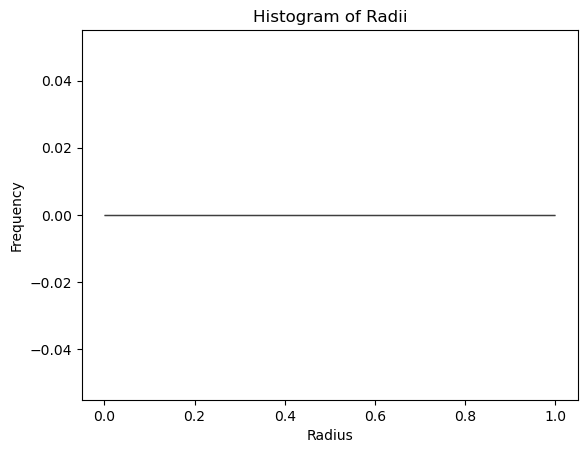

In [5]:
plt.hist(combined_radii, bins=500, edgecolor='k')
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Radii')
plt.show()

# radius =  map_value_linear(value, 0.003, 0.45, 2, 8)

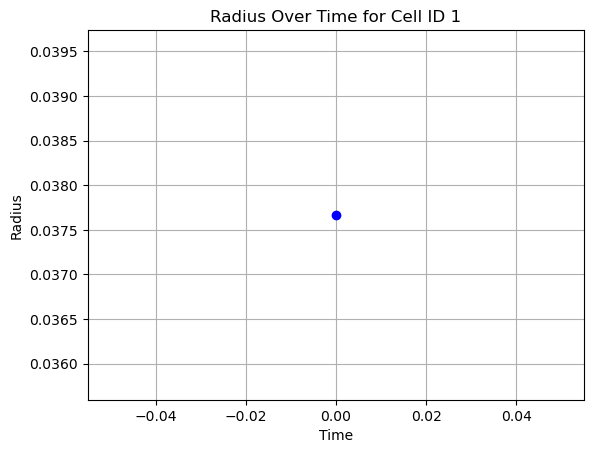

In [6]:
filepath = './'+str(1)+'_GT'+'/'+'pos_GT.txt'
cell_id = 1  # replace with your desired cell ID
plot_radius_over_time(filepath, cell_id)


In [7]:
x=0.034
c=0.03366667
b=[0.03366667,0.034,0.03466667]

print(x in b or c in b)

print(np.arange(1,4))

True
[1 2 3]


In [8]:
run=3
xl,yl,rl= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2), unpack=True)

x1=[]
y1=[]
x2_t=[]
y2_t=[]
x2=[]
y2=[]
x3=[]
y3=[]

for i in range(len(xl)):
    if i % 3 == 0:
        x1.append(xl[i])
        y1.append(yl[i])
        
    else:
        x2_t.append(xl[i])
        y2_t.append(yl[i])
        
for i in range(len(x2_t)):
    
    if i % 2 == 0:
        x2.append(x2_t[i])
        y2.append(y2_t[i])
        
    else:
        x3.append(x2_t[i])
        y3.append(y2_t[i])
        
        



plt.plot(x1,y1,c='red')
plt.plot(x2,y2,c='blue')
plt.plot(x3,y3,c='green')
plt.show()

FileNotFoundError: ./3_GT/pos_GT.txt not found.